In [1]:
import pandas as pd
import numpy as np
import glob as glob
import os
import cv2
import matplotlib.pyplot as plt
import argparse
import time
from tqdm.auto import tqdm
import keras
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torchvision
import torchvision.models as models
from torchvision import datasets, transforms
from torchvision.models._api import WeightsEnum
from torch.hub import load_state_dict_from_url
from torch.utils.data import DataLoader, random_split
from pytorch_model_summary import summary
import warnings
warnings.filterwarnings('ignore')

from Constant import *
from dataset import *


%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
if torch.cuda.is_available(): torch.cuda.manual_seed_all(SEED)
np.random.seed(SEED)

In [ ]:
#from torchvision import models
#dir(models)

In [5]:
gpu = torch.cuda.is_available()
gpu

False

In [7]:
#image = plt.imread("../data/Training/cats")
#plt.axis("off")
#plt.imshow(image)

In [5]:
dataset = keras.preprocessing.image_dataset_from_directory(TRAIN_PATH,
                                                           shuffle = True,
                                                           image_size = (IMAGE_SIZE, IMAGE_SIZE),
                                                           batch_size = BATCH_SIZE)

Found 1610 files belonging to 2 classes.


In [6]:
image_count = len(dataset)
image_count

101

In [7]:
class_names = dataset.class_names
print(class_names)
num_classes = len(class_names)
print(num_classes)

['cats', 'dogs']
2


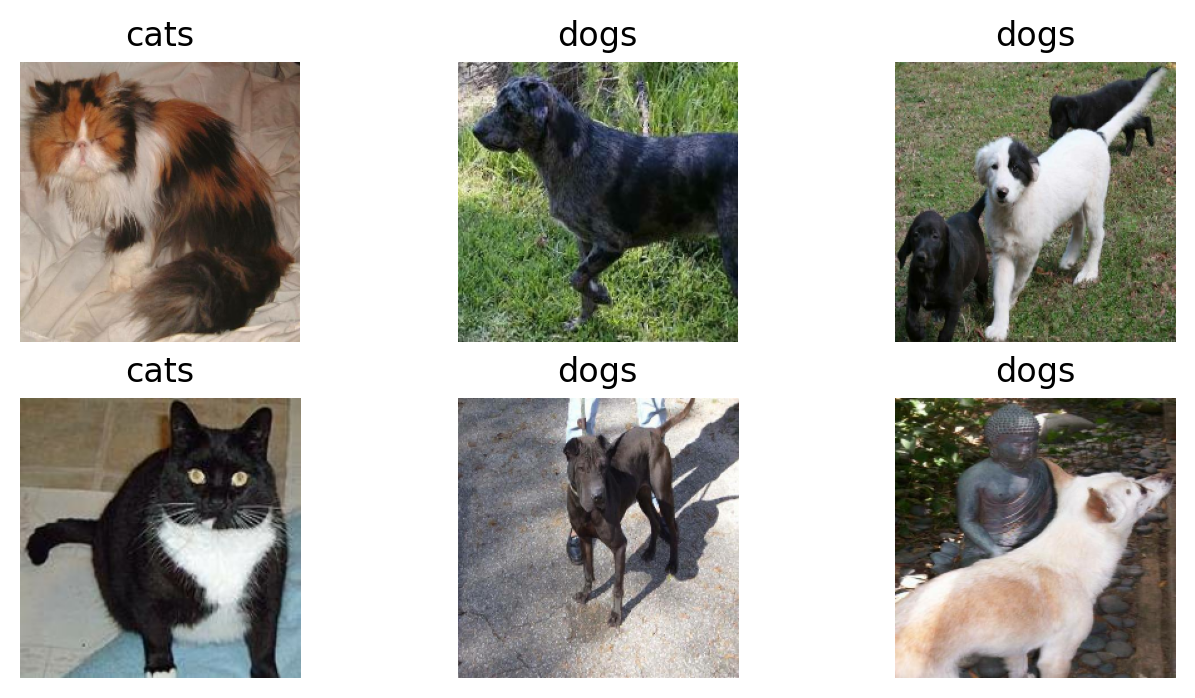

In [9]:
plt.figure(figsize = (8, 4))
for image_batch, label_batch in dataset.take(1):
    for i in range(6):
        ax = plt.subplot(2, 3, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [10]:
def train_preprocessing(IMAGE_SIZE):
    train_augmenting = transforms.Compose([
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        transforms.RandomHorizontalFlip(p = 0.5),
        transforms.RandomVerticalFlip(p = 0.5),
        transforms.GaussianBlur(kernel_size = (5, 9),sigma = (0.1, 5)),
        transforms.RandomAdjustSharpness(sharpness_factor = 2, p = 0.5),
        transforms.ToTensor(),
        transforms.Normalize(
            mean = [0.485, 0.465, 0.406],
            std = [0.229, 0.224, 0.225]
        )
    ])
    
    return train_augmenting

In [11]:
dataset = datasets.ImageFolder(TRAIN_PATH,
                               transform = (train_preprocessing(IMAGE_SIZE)))
dataset_size = [int(len(dataset) * 0.75), len(dataset) - int(len(dataset) * 0.75)]
train_set, validation_set = random_split(dataset, dataset_size)

def file_loader(train_set, validation_set):
    train_loader = DataLoader(
        train_set,
        batch_size = BATCH_SIZE,
        shuffle = True,
        num_workers = NUM_WORKERS
    )
    validation_loader = DataLoader(
        validation_set,
        batch_size = BATCH_SIZE,
        shuffle = False,
        num_workers = NUM_WORKERS
    )
    
    return train_loader, validation_loader

In [12]:
dataset.class_to_idx

{'cats': 0, 'dogs': 1}

In [23]:
plt.style.use('ggplot')

def save_model(epochs, model, optimizer, criterion):
    torch.save({
        'epoch' : epochs,
        'model_state_dict' : model.state_dict(),
        'optimizer_state_dict' : optimizer.state_dict(),
        'loss' : criterion,
    }, f"../outputs/model.pth")
    
    
def save_plots(train_accuracy, validation_accuracy, train_loss, validation_loss):
    # Accuracy plot
    plt.figure(figsize = (10, 8))
    plt.plot(train_accuracy, color = 'black', label = 'training accuracy')
    plt.plot(validation_accuracy, color = 'blue', label = 'validation accuracy')
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.savefig(f"../outputs/accuracy.png")
    
    # Loss plot
    plt.figure(figsize = (10, 8))
    plt.plot(train_loss, color = 'black', label = 'training loss')
    plt.plot(validation_loss, color = 'blue', label = 'validation loss')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.savefig(f"../outputs/loss.png")

In [3]:
def build_model(pretrained = True, fine_tune = True, num_classes = 4):
    """
    Builds a ResNet model for image classification.

    Args:
        pretrained (bool): Whether to load pre-trained weights.
        fine_tune (bool): Whether to fine-tune all layers.
        num_classes (int): Number of output classes.

    Returns:
        torch.nn.Module: The built model.
    """

    # Load the pre-trained ResNet model
    model = models.resnet18(pretrained = pretrained)

    # Freeze all layers if fine-tuning is not enabled
    if not fine_tune:
        for param in model.parameters():
            param.requires_grad = False

    # Change the final classification head to match the number of classes
    model.fc = nn.Linear(model.fc.in_features, num_classes)

    return model

In [25]:
def train(model, trainloader, optimizer, criterion):
    model.train()
    print("Training...")
    train_running_loss = 0.0
    train_running_correct = 0
    counter = 0
    
    for i, data in tqdm(enumerate(trainloader), total = len(trainloader)):
        counter += 1
        image, labels = data
        image = image.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        
        # Forward prop
        outputs = model(image)
        
        # Calculating loss
        loss = criterion(outputs, labels)
        train_running_loss += loss.item()
        
        # Calculating accuracy
        _, prediction = torch.max(outputs.data, 1)
        train_running_correct += (prediction == labels).sum().item()
        
        # Backward prop
        loss.backward()

        # Update weights
        optimizer.step()
        
    epoch_loss = train_running_loss / counter
    epoch_accuracy = 100 * (train_running_correct / len(trainloader.dataset))
    
    return epoch_loss, epoch_accuracy

In [26]:
def validate(model, testloader, criterion):
    model.eval()
    print('validation...')
    validation_running_loss = 0.0
    validation_running_correct = 0
    counter = 0
    
    with torch.no_grad():
        for i, data in tqdm(enumerate(testloader), total = len(testloader)):
            counter += 1
            image, labels = data
            image = image.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            
            # Forward prop
            outputs = model(image)
            
            # Calculating loss
            loss = criterion(outputs, labels)
            validation_running_loss += loss.item()
            
            # Calculating accuracy
            _, prediction = torch.max(outputs.data, 1)
            validation_running_correct += (prediction == labels).sum().item()
            
    epoch_loss = validation_running_loss / counter
    epoch_accuracy = 100 * (validation_running_correct / len(testloader.dataset))
    
    return epoch_loss, epoch_accuracy


In [27]:
args = {'learning_rate' : 0.0001, 'epochs' : 10}
dataset_classes = dataset.class_to_idx

In [28]:
# Load training and validation data loaders
train_loader, validation_loader = file_loader(train_set, validation_set)

Running on: cpu
Learning rate: 0.0001
Epochs: 10

11,177,538 parameters.
11,177,538 training parameters.
Epoch 1 of 10
Training...


  0%|          | 0/76 [00:00<?, ?it/s]

validation...


  0%|          | 0/26 [00:00<?, ?it/s]

Training loss: 0.341, Training accuracy: 84.673
Validation loss: 0.175, Validation accuracy: 92.804
~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ 
Epoch 2 of 10
Training...


  0%|          | 0/76 [00:00<?, ?it/s]

validation...


  0%|          | 0/26 [00:00<?, ?it/s]

Training loss: 0.157, Training accuracy: 93.538
Validation loss: 0.141, Validation accuracy: 92.556
~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ 
Epoch 3 of 10
Training...


  0%|          | 0/76 [00:00<?, ?it/s]

validation...


  0%|          | 0/26 [00:00<?, ?it/s]

Training loss: 0.156, Training accuracy: 94.283
Validation loss: 0.108, Validation accuracy: 95.533
~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ 
Epoch 4 of 10
Training...


  0%|          | 0/76 [00:00<?, ?it/s]

validation...


  0%|          | 0/26 [00:00<?, ?it/s]

Training loss: 0.105, Training accuracy: 95.940
Validation loss: 0.151, Validation accuracy: 95.037
~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ 
Epoch 5 of 10
Training...


  0%|          | 0/76 [00:00<?, ?it/s]

validation...


  0%|          | 0/26 [00:00<?, ?it/s]

Training loss: 0.084, Training accuracy: 96.603
Validation loss: 0.136, Validation accuracy: 94.541
~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ 
Epoch 6 of 10
Training...


  0%|          | 0/76 [00:00<?, ?it/s]

validation...


  0%|          | 0/26 [00:00<?, ?it/s]

Training loss: 0.067, Training accuracy: 97.432
Validation loss: 0.149, Validation accuracy: 95.037
~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ 
Epoch 7 of 10
Training...


  0%|          | 0/76 [00:00<?, ?it/s]

validation...


  0%|          | 0/26 [00:00<?, ?it/s]

Training loss: 0.062, Training accuracy: 98.012
Validation loss: 0.102, Validation accuracy: 95.285
~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ 
Epoch 8 of 10
Training...


  0%|          | 0/76 [00:00<?, ?it/s]

validation...


  0%|          | 0/26 [00:00<?, ?it/s]

Training loss: 0.089, Training accuracy: 97.763
Validation loss: 0.233, Validation accuracy: 91.315
~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ 
Epoch 9 of 10
Training...


  0%|          | 0/76 [00:00<?, ?it/s]

validation...


  0%|          | 0/26 [00:00<?, ?it/s]

Training loss: 0.094, Training accuracy: 96.852
Validation loss: 0.134, Validation accuracy: 95.782
~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ 
Epoch 10 of 10
Training...


  0%|          | 0/76 [00:00<?, ?it/s]

validation...


  0%|          | 0/26 [00:00<?, ?it/s]

Training loss: 0.089, Training accuracy: 96.355
Validation loss: 0.133, Validation accuracy: 95.037
~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ 
Done


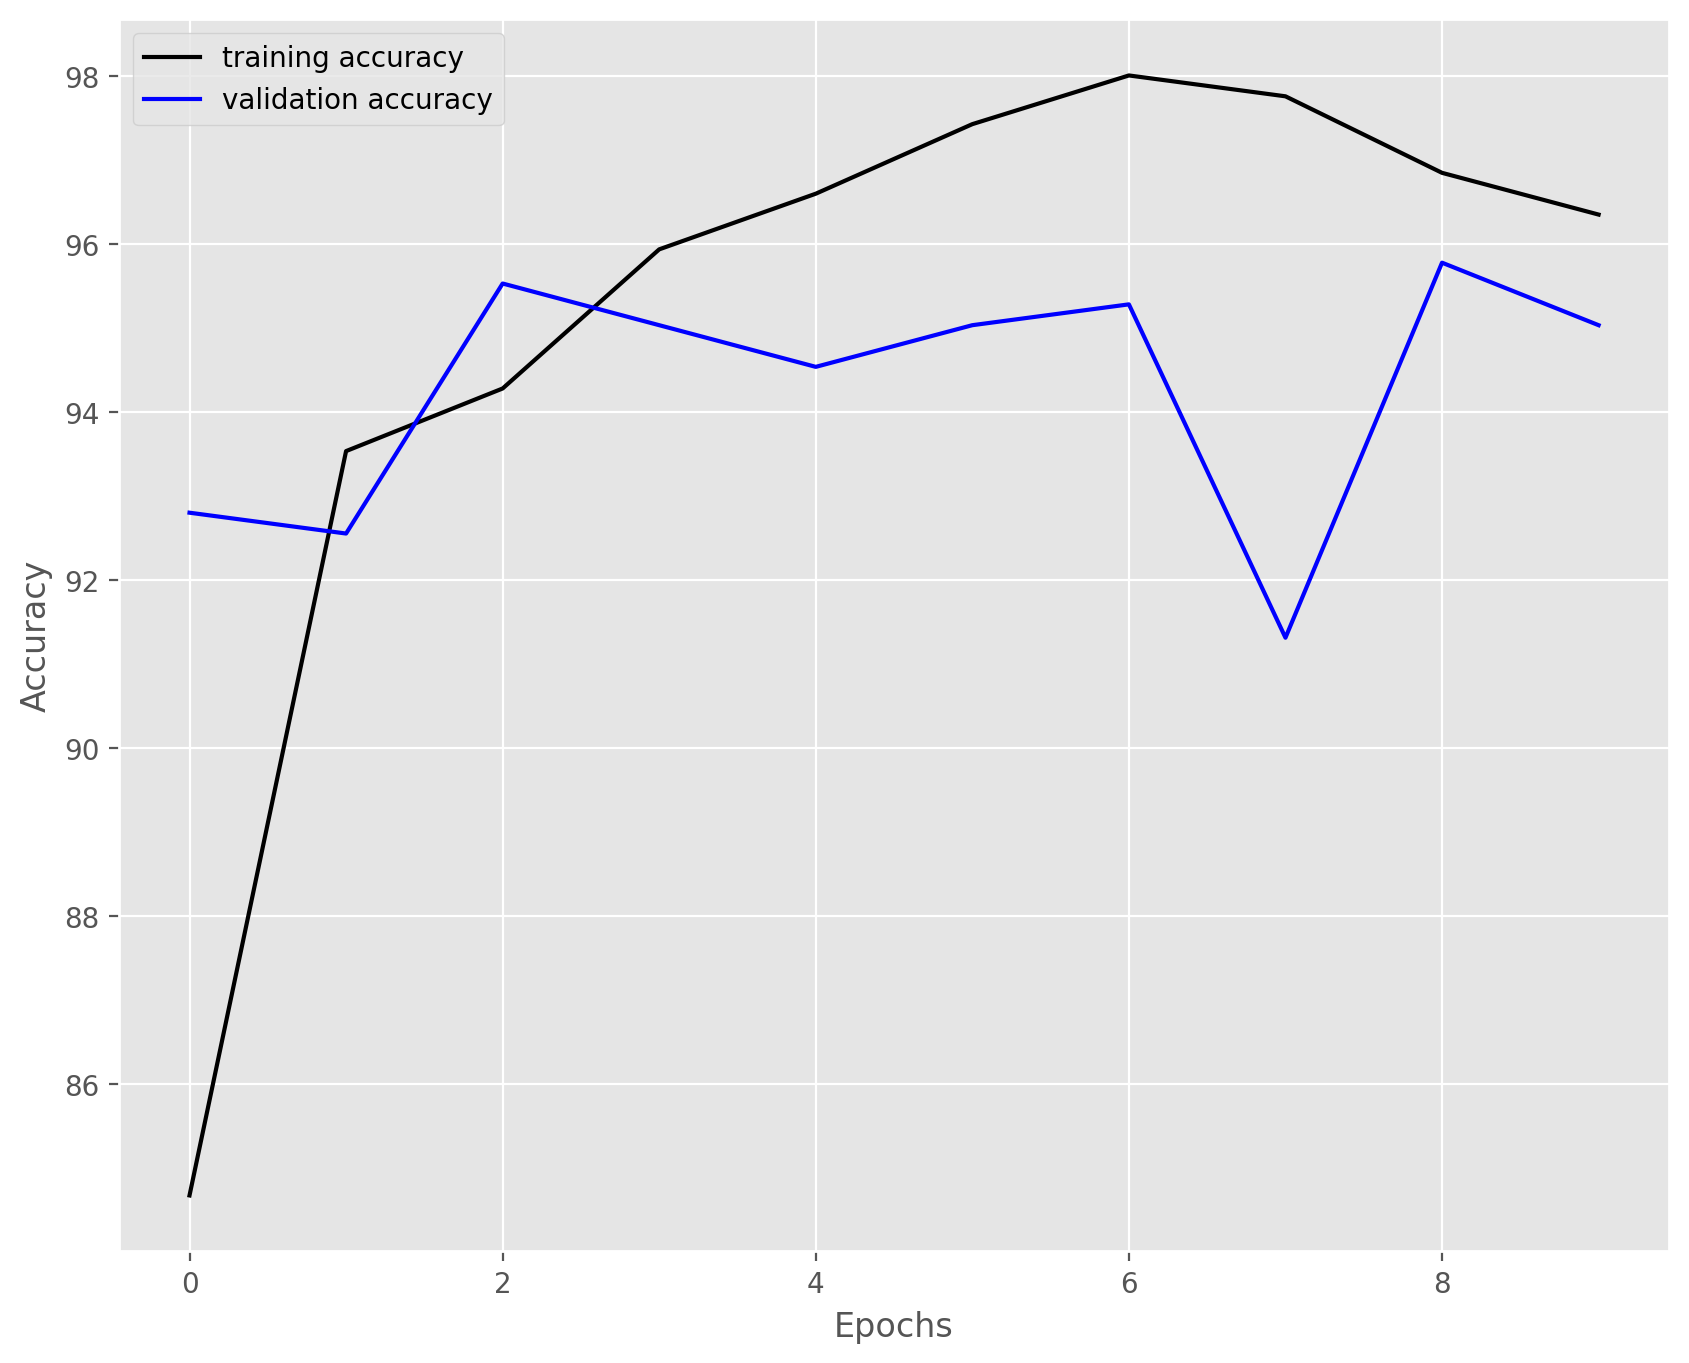

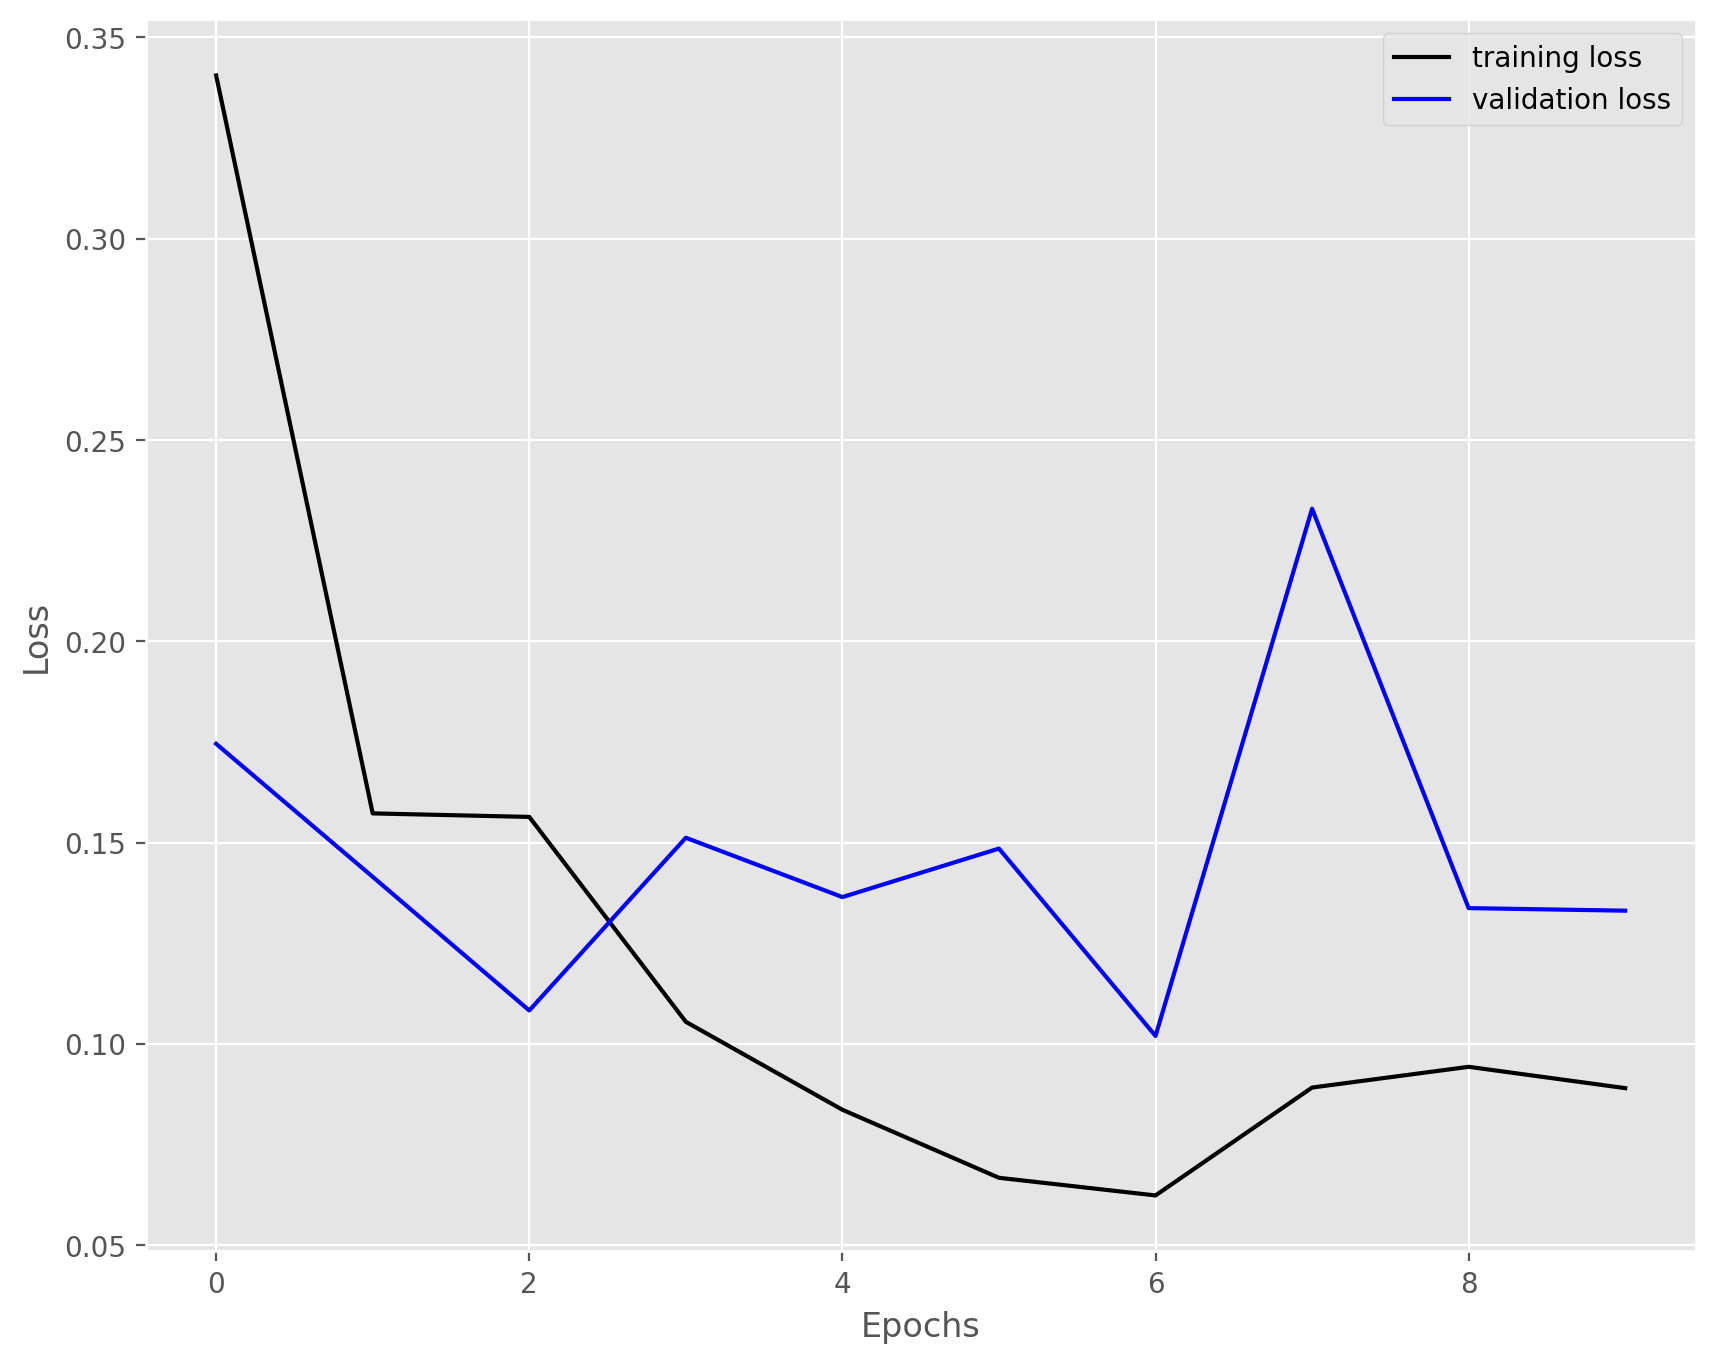

In [31]:
# Learning parameters
learning_rate = args['learning_rate']
epochs = args['epochs']
device = ('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Running on: {device}")
print(f"Learning rate: {learning_rate}")
print(f"Epochs: {epochs}\n")
    
model = build_model(
        pretrained = True,
        fine_tune = True,
        num_classes = len(dataset_classes)
    ).to(device)
    
 
    # Total parameters and trainable parameters
total_parameters = sum(p.numel() for p in model.parameters())
print(f"{total_parameters:,} parameters.")
trainable_parameters = sum(
        p.numel() for p in model.parameters() if p.requires_grad)
print(f"{trainable_parameters:,} training parameters.")
    
    # Optimizer
optimizer = optim.Adam(model.parameters(), lr = learning_rate)
    # Loss
criterion = nn.CrossEntropyLoss()
    
    # Tracking loss and accuracy
train_loss, validation_loss = [], []
train_accuracy, validation_accuracy = [], []
    
    # Train
for epoch in range(epochs):
    print(f"Epoch {epoch + 1} of {epochs}")
    train_loss_per_epoch, train_accuracy_per_epoch = train(model,
                                                               train_loader,
                                                               optimizer,
                                                               criterion)
    val_loss_per_epoch, val_accuracy_per_epoch = validate(model,
                                                              validation_loader,
                                                              criterion)
    train_loss.append(train_loss_per_epoch)
    validation_loss.append(val_loss_per_epoch)
    train_accuracy.append(train_accuracy_per_epoch)
    validation_accuracy.append(val_accuracy_per_epoch)
    print(f"Training loss: {train_loss_per_epoch:.3f}, Training accuracy: {train_accuracy_per_epoch:.3f}")
    print(f"Validation loss: {val_loss_per_epoch:.3f}, Validation accuracy: {val_accuracy_per_epoch:.3f}")
    print("~ " * 105)
    time.sleep(3)
        
    # Save model
save_model(epochs, model, optimizer, criterion)
    # Save loss and accuracy plots
save_plots(train_accuracy, validation_accuracy, train_loss, validation_loss)
print("Done")

In [ ]:
# Load saved model
model = build_model(pretrained = False, fine_tune = False, num_classes = 2)
checkpoint = torch.load("../outputs/model.pth", map_location = DEVICE)
#print("Loading saved model")
model.load_state_dict(checkpoint['model_state_dict'])

# Get test files
test_files = glob.glob(f"{TEST_PATH}/*")

# Iterate over images
for test_file in test_files:
    # Get true class name and make copy
    actual_class = test_file.split(os.path.sep)[-1].split('.')[0]
    image = cv2.imread(test_file)
    test_image = image.copy()
    
    # Preprocess images
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(
            mean = [0.485, 0.465, 0.406],
            std = [0.229, 0.224, 0.225]
        )
    ])
    image = transform(image)
    image = torch.unsqueeze(image, 0)
    image = image.to(DEVICE)
    
    # Test on image
    outputs = model(image)
    outputs = outputs.detach().numpy()
    predicted_class = class_names[np.argmax(outputs[0])]
    print(f"Actual class: {actual_class}, Predicted: {predicted_class.lower()}")
    
    # Inscribe the text onto the images
    cv2.putText(
        test_image,
        f"Actual: {actual_class}",
        (10, 20),
        cv2.FONT_HERSHEY_SIMPLEX,
        0.7,
        (100, 200, 125),
        1,
        lineType = cv2.LINE_AA
    )
    cv2.putText(
        test_image,
        f"Predicted: {predicted_class.lower()}",
        (10, 35),
        cv2.FONT_HERSHEY_SIMPLEX,
        0.7,
        #(100, 100, 225),
        (65, 65, 155),
        1,
        lineType = cv2.LINE_AA
    )
    
    cv2.imshow("Result", test_image)
    cv2.waitKey(0)
    cv2.imwrite(f"../outputs/{actual_class}.png", test_file)